<a href="https://colab.research.google.com/github/AnirudhAchal/WEC-REC-ML-Task/blob/main/WebClub_Rec_ML_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

!pip install catboost

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import seaborn as sns
import tensorflow as tf
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor

## Helper Functions

In [ ]:
# Function to load_data into np matrixs
def load_data_into_np(train_df, test_df):
    features = []
    label = []

    for column in train_df.columns:
        if column != 'O/P':
            features.append(column)
        else:
            label.append(column)

    X = train_df.loc[:, features].to_numpy().astype('float')
    y = train_df.loc[:, label].to_numpy().astype('float').ravel()
    X_predict = test_df.loc[:, :].to_numpy().astype('float')

    # Performing Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

    return X, y, X_train, y_train, X_test, y_test, X_predict, train_df, test_df

In [ ]:
# Function to load_data after new csv files have been saved
def load_data(train_file_name, test_file_name):
    # Mounting Google Drive
    drive.mount('/content/gdrive')
    # Importing Data
    train_df = pd.read_csv('gdrive/My Drive/wecrec2020/Data/' + train_file_name, index_col = 0)
    test_df = pd.read_csv('gdrive/My Drive/wecrec2020/Data/' + test_file_name, index_col = 0)

    features = []
    label = []

    for column in train_df.columns:
        if column != 'O/P':
            features.append(column)
        else:
            label.append(column)

    X = train_df.loc[:, features].to_numpy().astype('float')
    y = train_df.loc[:, label].to_numpy().astype('float').ravel()
    X_predict = test_df.loc[:, :].to_numpy().astype('float')

    # Performing Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

    return X, y, X_train, y_train, X_test, y_test, X_predict, train_df, test_df

In [ ]:
# Function to load_data with train / cv / test split after new csv files have been saved
def load_data_with_cv(train_file_name, test_file_name):
    # Mounting Google Drive
    drive.mount('/content/gdrive')
    # Importing Data
    train_df = pd.read_csv('gdrive/My Drive/wecrec2020/Data/' + train_file_name, index_col = 0)
    test_df = pd.read_csv('gdrive/My Drive/wecrec2020/Data/' + test_file_name, index_col = 0)

    features = []
    label = []

    for column in train_df.columns:
        if column != 'O/P':
            features.append(column)
        else:
            label.append(column)

    X = train_df.loc[:, features].to_numpy().astype('float')
    y = train_df.loc[:, label].to_numpy().astype('float').ravel()
    X_predict = test_df.loc[:, :].to_numpy().astype('float')

    # Performing Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    X_train, X_cv_temp, y_train, y_cv_temp = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)

    return X, y, X_train, y_train, X_test, y_test, X_cv_temp, y_cv_temp, X_predict, train_df, test_df


In [ ]:
# Function to Test Model on random test train splits
def test_model(model, count, X_temp, y_temp):
    for i in range(count):
        # Test train split
        X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y_temp, test_size = 0.2, random_state = i)

        # Fitting the model
        model.fit(X_train_temp, y_train_temp)
        
        # Making predictions and printing error
        y_predictions = np.maximum(model.predict(X_test_temp), np.ones(y_test_temp.shape[0]))
        
        print(f"Root Mean Square error of model Trial {i + 1}: ", mean_squared_error(y_predictions, y_test_temp, squared = False))

In [ ]:
# Function to get submission file
def get_prediction_file(model, filename, num):
    # Making predictions
    test_X = test_df.loc[:, :].to_numpy().astype('float')

    # For XGB
    X_predict = xgb.DMatrix(test_X)
    predictions_y = (np.power(model.predict(X_predict), num))
    # predictions_y = np.power(np.maximum(model.predict(test_X), np.ones(test_X.shape[0])), num)

    # Setting up submission dataframe
    df_submission = pd.DataFrame({'Id' : test_df.index, 'PredictedValue' : predictions_y.ravel()})
    
    # Setting path
    submission_file_path = 'gdrive/My Drive/wecrec2020/SubmissionFiles/' + filename

    # write to the file
    df_submission.to_csv(submission_file_path, index = False)


In [ ]:
# Function to evaluate a trained model
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    print('Model Performance')
    print('Root Mean Square Error: {:0.4f}'.format(mean_squared_error(predictions, test_labels, squared = False)))

In [ ]:
# Function to compare the differences between prediction files
def compare_preditions(file1, file2):
    # Mounting Google Drive
    drive.mount('/content/gdrive')

    # Importing Data
    y1_df = pd.read_csv('gdrive/My Drive/wecrec2020/SubmissionFiles/' + file1, index_col = 0)
    y2_df = pd.read_csv('gdrive/My Drive/wecrec2020/SubmissionFiles/' + file2, index_col = 0)

    y1 = y1_df.to_numpy().astype('float').ravel()
    y2 = y2_df.to_numpy().astype('float').ravel()

    print(f"Root Mean Square error : ", mean_squared_error(y1, y2, squared = False))

In [ ]:
# Function to plot Train, Crossvalidation vs number of epochs of iterations rmse
def plot_log(history, start):
    # summarize history for loss    
    plt.plot(history.history['loss'][start:])
    plt.plot(history.history['val_loss'][start:])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'cross validation'], loc='upper left')
    plt.show()

In [ ]:
# Function to plot Train, Crossvalidation vs number of epochs of iterations rmse for XGBoost
def plot_log_xgb(history, start):
    # summarize history for loss    
    plt.plot(history['validation_0']['rmse'][start:])
    plt.plot(history['validation_1']['rmse'][start:])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'cross validation'], loc='upper left')
    plt.show()

# PART 1 : Training on original dataset

In [ ]:
# Importing Data
train_df = pd.read_csv('gdrive/My Drive/wecrec2020/Data/Train_data.csv', index_col = 0)
test_df = pd.read_csv('gdrive/My Drive/wecrec2020/Data/Test_data.csv', index_col = 0)
train_df.drop(['F1', 'F2'], inplace = True, axis = 1) 
test_df.drop(['F1', 'F2'], inplace = True, axis = 1) 

In [ ]:
train_df.head()

,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,O/P
0,1,0,1,14513,0,0,6,8,0,1,0.24,0.907824,0.2879,0.81,0.0,16
1,1,0,1,1790,1,0,6,13,0,1,0.22,0.035276,0.2727,0.80,0.0,40
2,1,0,1,17027,2,0,6,17,0,1,0.22,0.069405,0.2727,0.80,0.0,32
3,1,0,1,16889,3,0,6,17,0,1,0.24,0.835692,0.2879,0.75,0.0,13
4,1,0,1,5041,4,0,6,8,0,1,0.24,0.876817,0.2879,0.75,0.0,1


In [ ]:
test_df.head()

,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17
14000,3,1,8,10317,13,0,6,8,0,1,0.80,-0.652184,0.7424,0.49,0.3582
14001,3,1,8,11213,14,0,6,22,0,1,0.80,0.338563,0.7424,0.49,0.2985
14002,3,1,8,15700,15,0,6,12,0,1,0.80,-1.171582,0.7273,0.46,0.2836
14003,3,1,8,2030,16,0,6,29,0,1,0.80,-0.517499,0.7273,0.46,0.2985
14004,3,1,8,15427,17,0,6,7,0,3,0.74,0.393391,0.6970,0.66,0.3582


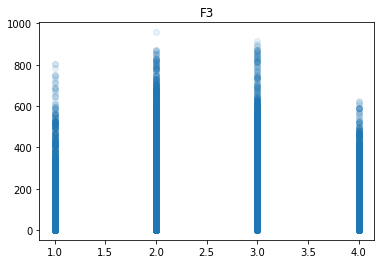

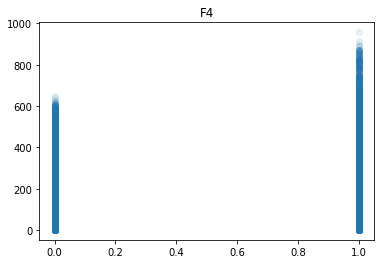

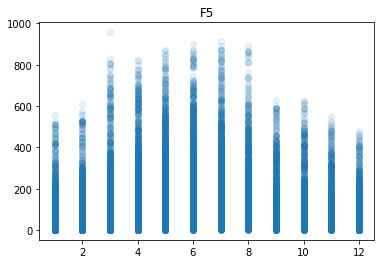

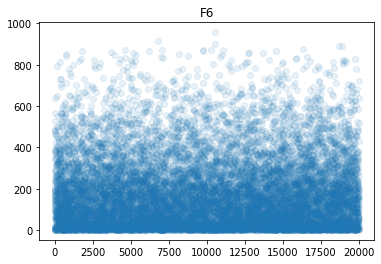

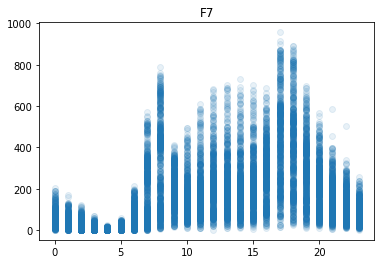

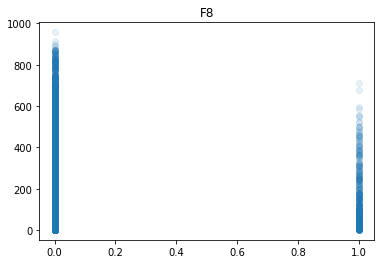

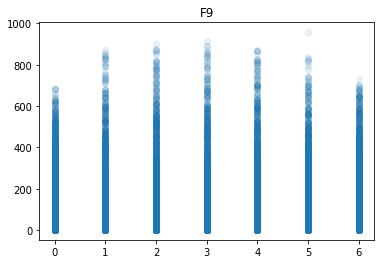

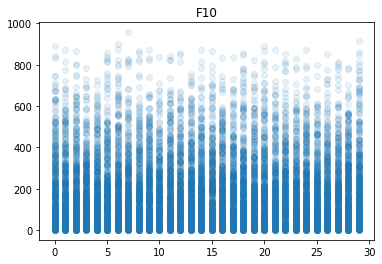

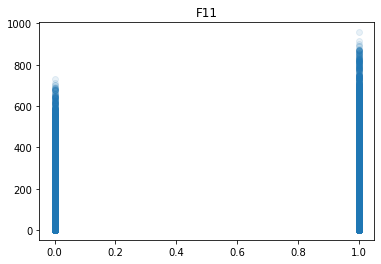

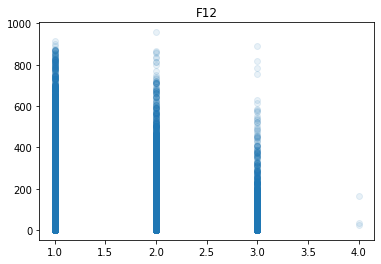

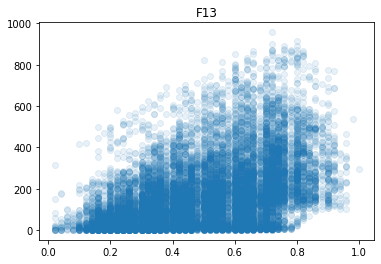

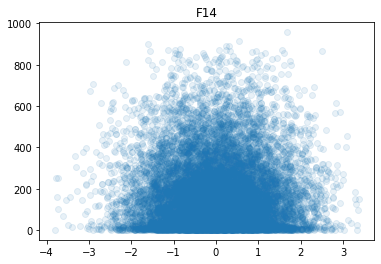

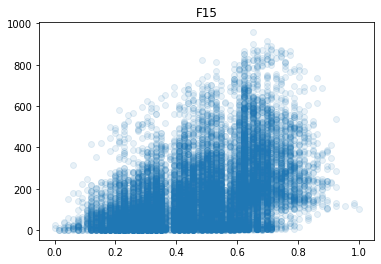

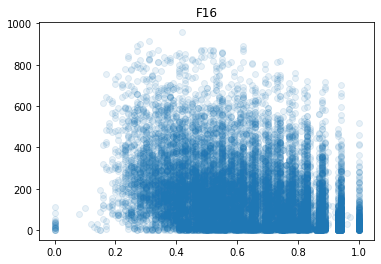

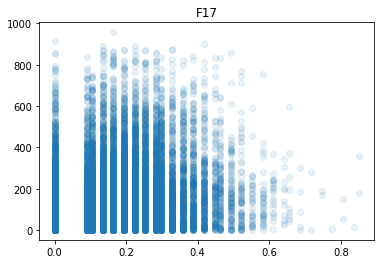

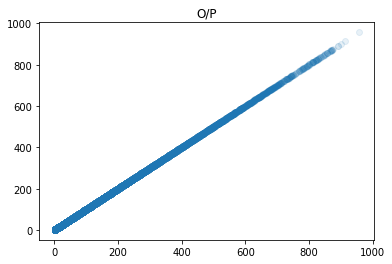

In [ ]:
for column in train_df.columns:
    plt.scatter(train_df[column], train_df['O/P'], alpha = 0.1)
    plt.title(column)
    plt.show()

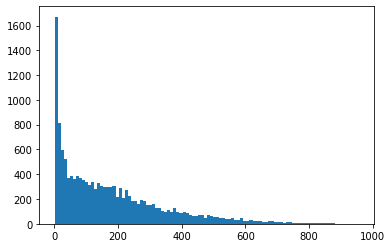

In [ ]:
plt.hist(train_df['O/P'], bins = 100)
plt.show()

In [ ]:
X, y, X_train, y_train, X_test, y_test, X_predict, train_df, test_df = load_data_into_np(train_df, test_df)

## Dummy Model

In [ ]:
dummy_model = DummyRegressor(strategy = "mean")

test_model(dummy_model, 1, X, y)

# get_prediction_file(dummy_model, 'Dummy_model.csv', 1)

Root Mean Square error of model Trial 1:  169.72809697310743


## Baseline Model

In [ ]:
rf = RandomForestRegressor(n_estimators = 50, random_state = 43)

rf.fit(X, y)

test_model(rf, 1, X, y)

# get_prediction_file(rf, 'baseline.csv', 1)

Root Mean Square error of model Trial 1:  43.572339949953175


## Model 1 : Linear Regression

In [ ]:
lr_model_1 = LinearRegression()

test_model(lr_model_1, 1, X, y)

# get_prediction_file(dummy_model, 'Dummy_model.csv', 1)

Root Mean Square error of model Trial 1:  130.1562842983415


## Model 2 : Lasso Regression

In [ ]:
clf = Lasso(alpha=10, max_iter=100000)

test_model(clf, 1, X, y)

# get_prediction_file(clf, 'lasso_1.0.csv', 1)

Root Mean Square error of model Trial 1:  146.33310673436162


## Model 3 : Neural Networks (MLP Regressor)

In [ ]:
from sklearn.neural_network import MLPRegressor

regr_1 = MLPRegressor(random_state = 1, max_iter = 10000)

test_model(regr_1, 1, X, y)

# get_prediction_file(regr_1, 'nn_1.3.csv', 1)

Root Mean Square error of model Trial 1:  135.85966597182608


## Model 4 : Random Forest Regressor (with Hyper Parameter Tuning)

In [ ]:
# Create the parameter grid

param_grid = {
    'max_depth': [20, 30, 40],
    'n_estimators': [100, 110, 120,], 
    'min_samples_split': [2, 3, 4],
    'random_state' : [47],
}

# Create a based model
rf = RandomForestRegressor()

grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 10)

grid_search_rf.fit(X_train, y_train)

# Best Parameter Values
best_grid = grid_search_rf.best_estimator_
print(best_grid)

# Evaluating the model
evaluate(best_grid, X_test, y_test)

# Getting submission file
# get_prediction_file(best_grid, 'rfr_final.csv', 1)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  9

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=110, n_jobs=None, oob_score=False,
                      random_state=47, verbose=0, warm_start=False)
Model Performance
Root Mean Square Error: 43.3298


##Model 5 : XGBoost (with Hyper Parameter Tuning)

[0]	validation_0-rmse:223.898	validation_1-rmse:226.715
[1]	validation_0-rmse:207.871	validation_1-rmse:210.367
[2]	validation_0-rmse:193.643	validation_1-rmse:195.82
[3]	validation_0-rmse:181.107	validation_1-rmse:183.012
[4]	validation_0-rmse:169.782	validation_1-rmse:171.412
[5]	validation_0-rmse:159.881	validation_1-rmse:161.293
[6]	validation_0-rmse:151.018	validation_1-rmse:152.2
[7]	validation_0-rmse:142.43	validation_1-rmse:143.419
[8]	validation_0-rmse:135.379	validation_1-rmse:136.23
[9]	validation_0-rmse:129.153	validation_1-rmse:129.98
[10]	validation_0-rmse:122.551	validation_1-rmse:123.308
[11]	validation_0-rmse:116.046	validation_1-rmse:116.836
[12]	validation_0-rmse:110.552	validation_1-rmse:111.377
[13]	validation_0-rmse:105.754	validation_1-rmse:106.517
[14]	validation_0-rmse:100.756	validation_1-rmse:101.572
[15]	validation_0-rmse:96.1496	validation_1-rmse:97.0027
[16]	validation_0-rmse:91.9798	validation_1-rmse:92.8724
[17]	validation_0-rmse:88.4939	validation_1-rms

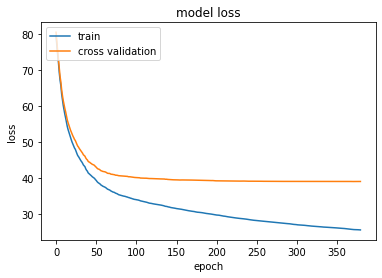

Root Mean Square error of model Trial :  38.99235967697746


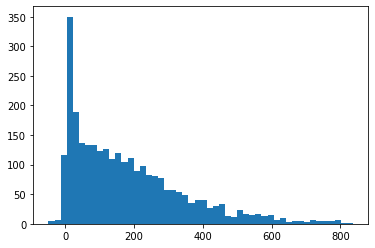

In [ ]:
param = {
    'max_depth': 10, 
    'eta': 10, 
    'objective': 'reg:squarederror', 
    'eval_metric' : 'rmse', 
    'n_estimators' : 400, 
    'reg_lambda' : 100, 
    'min_child_weight': 70, 
    'subsample' : 1, 
    'reg_alpha' : 50
    }

clf = XGBRegressor(**param)

clf.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), (X_test, y_test)], 
        eval_metric = 'rmse', 
        verbose = True)

evals_result = clf.evals_result()

plot_log_xgb(evals_result, 20)
print(f"Root Mean Square error of model Trial : ", mean_squared_error(np.power(clf.predict(X_test), 1), np.power(y_test, 1), squared = False))
plt.hist(np.power(clf.predict(X_test), 1), bins = 50)
plt.show()

[14:04:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:231.369	validation_1-rmse:234.181
[1]	validation_0-rmse:221.407	validation_1-rmse:224.033
[2]	validation_0-rmse:210.656	validation_1-rmse:213.111
[3]	validation_0-rmse:203.306	validation_1-rmse:205.602
[4]	validation_0-rmse:195.983	validation_1-rmse:198.109
[5]	validation_0-rmse:188.92	validation_1-rmse:190.881
[6]	validation_0-rmse:180.428	validation_1-rmse:182.276
[7]	validation_0-rmse:176.004	validation_1-rmse:177.761
[8]	validation_0-rmse:168.946	validation_1-rmse:170.629
[9]	validation_0-rmse:162.244	validation_1-rmse:163.741
[10]	validation_0-rmse:157.701	validation_1-rmse:159.03
[11]	validation_0-rmse:154.048	validation_1-rmse:155.314
[12]	validation_0-rmse:148.758	validation_1-rmse:149.901
[13]	validation_0-rmse:144.055	validation_1-rmse:145.124
[14]	validation_0-rmse:141.216	validation_1-rmse:142.179
[15]	validation_0-rmse:138.62	

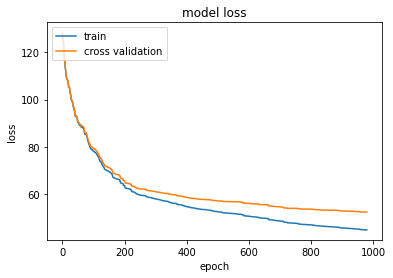

Root Mean Square error of model Trial :  52.38614849097635


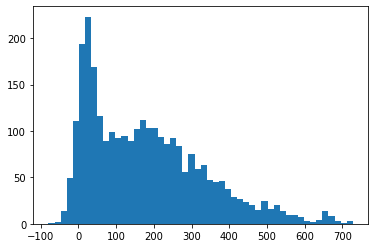

In [ ]:
clf = XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
clf.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), (X_test, y_test)], 
        eval_metric = 'rmse', 
        verbose = True)

evals_result = clf.evals_result()

plot_log_xgb(evals_result, 20)
print(f"Root Mean Square error of model Trial : ", mean_squared_error(np.power(clf.predict(X_test), 1), np.power(y_test, 1), squared = False))
plt.hist(np.power(clf.predict(X_test), 1), bins = 50)
plt.show()

In [ ]:
# Loading data in to DMatrix
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

# Create the parameter grid based
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

num_boost_rounds = 10000

# Training on Default parameters
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round = num_boost_rounds,
    evals = [(dtest, "Test")],
    early_stopping_rounds = 10
)

print("Best RSME: {:.2f} with {} rounds".format(
                 xgb_model.best_score,
                 xgb_model.best_iteration+1))

[0]	Test-rmse:183.331
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:142.976
[2]	Test-rmse:116.816
[3]	Test-rmse:94.7733
[4]	Test-rmse:81.6909
[5]	Test-rmse:73.1777
[6]	Test-rmse:62.5623
[7]	Test-rmse:56.446
[8]	Test-rmse:54.2146
[9]	Test-rmse:51.4717
[10]	Test-rmse:50.126
[11]	Test-rmse:49.1327
[12]	Test-rmse:48.3314
[13]	Test-rmse:48.0072
[14]	Test-rmse:46.422
[15]	Test-rmse:45.689
[16]	Test-rmse:45.517
[17]	Test-rmse:45.1121
[18]	Test-rmse:44.8768
[19]	Test-rmse:44.5082
[20]	Test-rmse:44.3907
[21]	Test-rmse:44.3609
[22]	Test-rmse:44.0537
[23]	Test-rmse:43.7964
[24]	Test-rmse:43.7964
[25]	Test-rmse:43.8413
[26]	Test-rmse:43.643
[27]	Test-rmse:43.5415
[28]	Test-rmse:43.3093
[29]	Test-rmse:43.2476
[30]	Test-rmse:43.234
[31]	Test-rmse:43.1957
[32]	Test-rmse:43.1942
[33]	Test-rmse:43.1038
[34]	Test-rmse:43.1045
[35]	Test-rmse:43.0817
[36]	Test-rmse:43.0949
[37]	Test-rmse:42.6125
[38]	Test-rmse:42.6379
[39]	Test-rmse:42.6414
[40]	Test-rmse:42.6221
[41]	Test-rmse:42

In [ ]:
# Testing cv 
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round = num_boost_rounds,
    seed = 42,
    nfold = 5,
    metrics = {'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,181.401755,0.841329,181.644107,4.455984
1,141.550928,0.680587,141.868829,3.914593
2,115.546282,0.642508,116.256383,3.548255
3,94.963912,1.023234,95.907786,3.568956
4,80.911617,0.901603,82.238924,3.366212
...,...,...,...,...
68,25.362602,0.501214,41.164581,1.244207
69,25.213814,0.444358,41.140118,1.231776
70,25.059021,0.407018,41.125331,1.224377
71,24.900264,0.398235,41.133930,1.244890


In [ ]:
cv_results['test-rmse-mean'].min()

41.10517359999999

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in np.arange(4, 10, 1)
    for min_child_weight in np.arange(1, 14, 2)
]

min_rmse = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(max_depth, min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_rounds,
        seed = 42,
        nfold = 5,
        metrics={'rmse'},
        early_stopping_rounds = 10
    )
    # Update best rmse

    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()

    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=4, min_child_weight=1
	RMSE 44.3861428 for 168 rounds
CV with max_depth=4, min_child_weight=3
	RMSE 45.0572892 for 90 rounds
CV with max_depth=4, min_child_weight=5
	RMSE 44.15694560000001 for 227 rounds
CV with max_depth=4, min_child_weight=7
	RMSE 44.357511200000005 for 138 rounds
CV with max_depth=4, min_child_weight=9
	RMSE 43.472424200000006 for 202 rounds
CV with max_depth=4, min_child_weight=11
	RMSE 43.9712234 for 189 rounds
CV with max_depth=4, min_child_weight=13
	RMSE 43.897883 for 170 rounds
CV with max_depth=5, min_child_weight=1
	RMSE 41.825539199999994 for 97 rounds
CV with max_depth=5, min_child_weight=3
	RMSE 42.012508399999994 for 87 rounds
CV with max_depth=5, min_child_weight=5
	RMSE 42.111143399999996 for 85 rounds
CV with max_depth=5, min_child_weight=7
	RMSE 42.32937019999999 for 89 rounds
CV with max_depth=5, min_child_weight=9
	RMSE 42.125845999999996 for 116 rounds
CV with max_depth=5, min_child_weight=11
	RMSE 42.1058838 for 91 rounds
CV wit

In [ ]:
# Setting best parameters
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/20. for i in range(10,21)]
    for colsample in [i/20. for i in range(10,21)]
]

min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(subsample, colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_rounds,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	RMSE 39.822316 for 31 rounds
CV with subsample=1.0, colsample=0.95
	RMSE 40.5727572 for 34 rounds
CV with subsample=1.0, colsample=0.9
	RMSE 40.993710199999995 for 37 rounds
CV with subsample=1.0, colsample=0.85
	RMSE 41.936017400000004 for 49 rounds
CV with subsample=1.0, colsample=0.8
	RMSE 41.936017400000004 for 49 rounds
CV with subsample=1.0, colsample=0.75
	RMSE 42.170768800000005 for 46 rounds
CV with subsample=1.0, colsample=0.7
	RMSE 42.364683400000004 for 38 rounds
CV with subsample=1.0, colsample=0.65
	RMSE 42.4376046 for 43 rounds
CV with subsample=1.0, colsample=0.6
	RMSE 42.4376046 for 43 rounds
CV with subsample=1.0, colsample=0.55
	RMSE 46.865373399999996 for 63 rounds
CV with subsample=1.0, colsample=0.5
	RMSE 46.64870599999999 for 98 rounds
CV with subsample=0.95, colsample=1.0
	RMSE 40.808483 for 40 rounds
CV with subsample=0.95, colsample=0.95
	RMSE 40.5762352 for 27 rounds
CV with subsample=0.95, colsample=0.9
	RMSE 40.9802992 

In [ ]:
# Setting best parameters
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

In [ ]:
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, 0.02, 0.01]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_rounds,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

CV with eta=0.3
	RMSE 39.822316 for 31 rounds

CV with eta=0.2
	RMSE 39.235552999999996 for 50 rounds

CV with eta=0.1
	RMSE 38.4092514 for 152 rounds

CV with eta=0.05
	RMSE 38.3169134 for 226 rounds

CV with eta=0.02
	RMSE 38.117869400000004 for 683 rounds

CV with eta=0.01
	RMSE 38.1334648 for 1251 rounds

Best params: 0.02, RMSE: 38.117869400000004


In [ ]:
params['eta'] = best_params

In [ ]:
gridsearch_params = [
    (reg_lambda)
    for reg_lambda in np.arange(1, 10)
]

In [ ]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for reg_lambda in gridsearch_params:
    print("CV with reg_lambda={}".format(reg_lambda))
    # We update our parameters
    params['reg_lambda'] = reg_lambda

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_rounds,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = reg_lambda
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

CV with reg_lambda=1
	RMSE 38.117869400000004 for 683 rounds
CV with reg_lambda=2
	RMSE 37.9570274 for 594 rounds
CV with reg_lambda=3
	RMSE 37.8738052 for 707 rounds
CV with reg_lambda=4
	RMSE 37.8312636 for 690 rounds
CV with reg_lambda=5
	RMSE 37.869194 for 700 rounds
CV with reg_lambda=6
	RMSE 37.928486799999995 for 675 rounds
CV with reg_lambda=7
	RMSE 37.9088684 for 749 rounds
CV with reg_lambda=8
	RMSE 38.027071400000004 for 613 rounds
CV with reg_lambda=9
	RMSE 38.0468216 for 683 rounds
Best params: 4, RMSE: 37.8312636


In [ ]:
params['reg_lambda'] = best_params

In [ ]:
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_rounds,
    evals=[(dtest, "Test")],
    early_stopping_rounds = 10
)

# get_prediction_file(xgb_model, 'XGB_final_1.csv', 1)

[0]	Test-rmse:240.393
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:236.07
[2]	Test-rmse:231.84
[3]	Test-rmse:227.696
[4]	Test-rmse:223.639
[5]	Test-rmse:219.646
[6]	Test-rmse:215.751
[7]	Test-rmse:211.969
[8]	Test-rmse:208.243
[9]	Test-rmse:204.619
[10]	Test-rmse:201.08
[11]	Test-rmse:197.621
[12]	Test-rmse:194.234
[13]	Test-rmse:190.853
[14]	Test-rmse:187.633
[15]	Test-rmse:184.47
[16]	Test-rmse:181.382
[17]	Test-rmse:178.3
[18]	Test-rmse:175.341
[19]	Test-rmse:172.401
[20]	Test-rmse:169.561
[21]	Test-rmse:166.728
[22]	Test-rmse:163.994
[23]	Test-rmse:161.266
[24]	Test-rmse:158.634
[25]	Test-rmse:156.03
[26]	Test-rmse:153.51
[27]	Test-rmse:151.037
[28]	Test-rmse:148.627
[29]	Test-rmse:146.301
[30]	Test-rmse:144.007
[31]	Test-rmse:141.721
[32]	Test-rmse:139.477
[33]	Test-rmse:137.299
[34]	Test-rmse:135.152
[35]	Test-rmse:133.117
[36]	Test-rmse:131.089
[37]	Test-rmse:129.098
[38]	Test-rmse:127.161
[39]	Test-rmse:125.238
[40]	Test-rmse:123.387
[41]	Test-rmse:121

#Part 2 : Removing Redundant Columns

In [ ]:
test_df['O/P'] = -1

# Concatinating train_f and test_df to process them simultaneously
df = pd.concat((train_df, test_df), axis = 0)

In [ ]:
df = df.astype('float64') 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 17378
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F3      17379 non-null  float64
 1   F4      17379 non-null  float64
 2   F5      17379 non-null  float64
 3   F6      17379 non-null  float64
 4   F7      17379 non-null  float64
 5   F8      17379 non-null  float64
 6   F9      17379 non-null  float64
 7   F10     17379 non-null  float64
 8   F11     17379 non-null  float64
 9   F12     17379 non-null  float64
 10  F13     17379 non-null  float64
 11  F14     17379 non-null  float64
 12  F15     17379 non-null  float64
 13  F16     17379 non-null  float64
 14  F17     17379 non-null  float64
 15  O/P     17379 non-null  float64
dtypes: float64(16)
memory usage: 2.3 MB


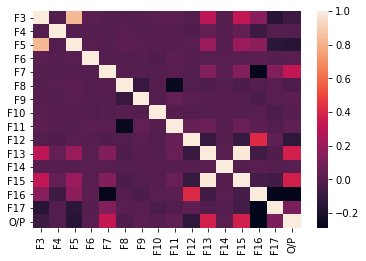

In [ ]:
# calculate the correlation matrix
corr = df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [ ]:
correlated_features = set()
correlation_matrix = df.corr()

removed_columns = []

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            print(i, j)
            correlated_features.add(colname)
            if colname not in removed_columns:
                removed_columns.append(colname)

df.drop(labels=correlated_features, axis=1, inplace=True)

2 0
12 10


{'F5', 'F15'}
['F5', 'F15']


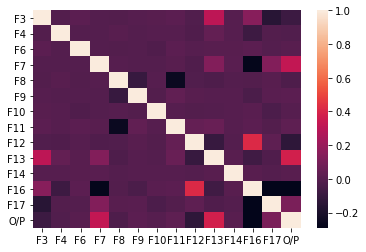

In [ ]:
print(correlated_features)
print(removed_columns)
# calculate the correlation matrix
corr = df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [ ]:
print(removed_columns)
df.info()

['F5', 'F15']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F3      17379 non-null  float64
 1   F4      17379 non-null  float64
 2   F6      17379 non-null  float64
 3   F7      17379 non-null  float64
 4   F8      17379 non-null  float64
 5   F9      17379 non-null  float64
 6   F10     17379 non-null  float64
 7   F11     17379 non-null  float64
 8   F12     17379 non-null  float64
 9   F13     17379 non-null  float64
 10  F14     17379 non-null  float64
 11  F16     17379 non-null  float64
 12  F17     17379 non-null  float64
 13  O/P     17379 non-null  float64
dtypes: float64(14)
memory usage: 2.0 MB


In [ ]:
train_df = df.loc[0:(14000-1), :]
test_df = df.loc[14000:, :]
test_df.drop('O/P', inplace = True, axis = 1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14000 entries, 0 to 13999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F3      14000 non-null  float64
 1   F4      14000 non-null  float64
 2   F6      14000 non-null  float64
 3   F7      14000 non-null  float64
 4   F8      14000 non-null  float64
 5   F9      14000 non-null  float64
 6   F10     14000 non-null  float64
 7   F11     14000 non-null  float64
 8   F12     14000 non-null  float64
 9   F13     14000 non-null  float64
 10  F14     14000 non-null  float64
 11  F16     14000 non-null  float64
 12  F17     14000 non-null  float64
 13  O/P     14000 non-null  float64
dtypes: float64(14)
memory usage: 1.6 MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3379 entries, 14000 to 17378
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F3      3379 non-null   float64
 1   F4      3379 non-null   float64
 2   F6      3379 non-null   float64
 3   F7      3379 non-null   float64
 4   F8      3379 non-null   float64
 5   F9      3379 non-null   float64
 6   F10     3379 non-null   float64
 7   F11     3379 non-null   float64
 8   F12     3379 non-null   float64
 9   F13     3379 non-null   float64
 10  F14     3379 non-null   float64
 11  F16     3379 non-null   float64
 12  F17     3379 non-null   float64
dtypes: float64(13)
memory usage: 369.6 KB


In [ ]:
# save_files('Train_data_def_2.csv', 'Test_data_def_2.csv')
X, y, X_train, y_train, X_test, y_test, X_predict, train_df, test_df = load_data_into_np(train_df, test_df)

## Model 1 : Random Forest Regressor (with Hyper Parameter Tuning)

In [ ]:
# Create the parameter grid

param_grid = {
    'max_depth': [10, 20, 30],
    'n_estimators': [90, 110, 120], 
    'min_samples_split': [1, 2, 3, 4, 5],
    'random_state' : [47],
}

# Create a based model
rf = RandomForestRegressor()

grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 10)

grid_search_rf.fit(X_train, y_train)

# Best Parameter Values
best_grid = grid_search_rf.best_estimator_
print(best_grid)

# Evaluating the model
evaluate(best_grid, X_test, y_test)

# Getting submission file
# get_prediction_file(best_grid, 'rfr_final_2.csv', 1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.5min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=110, n_jobs=None, oob_score=False,
                      random_state=47, verbose=0, warm_start=False)
Model Performance
Root Mean Square Error: 45.1266


##Model 2 : XGBoost (with Hyper Parameter Tuning)

[0]	validation_0-rmse:223.898	validation_1-rmse:226.715
[1]	validation_0-rmse:207.878	validation_1-rmse:210.393
[2]	validation_0-rmse:193.64	validation_1-rmse:195.801
[3]	validation_0-rmse:181.025	validation_1-rmse:183.016
[4]	validation_0-rmse:169.745	validation_1-rmse:171.364
[5]	validation_0-rmse:159.865	validation_1-rmse:161.278
[6]	validation_0-rmse:150.738	validation_1-rmse:151.9
[7]	validation_0-rmse:142.934	validation_1-rmse:143.876
[8]	validation_0-rmse:135.419	validation_1-rmse:136.238
[9]	validation_0-rmse:128.405	validation_1-rmse:129.052
[10]	validation_0-rmse:122.545	validation_1-rmse:123.148
[11]	validation_0-rmse:116.218	validation_1-rmse:116.736
[12]	validation_0-rmse:110.767	validation_1-rmse:111.327
[13]	validation_0-rmse:106.121	validation_1-rmse:106.617
[14]	validation_0-rmse:101.67	validation_1-rmse:102.171
[15]	validation_0-rmse:97.1515	validation_1-rmse:97.6544
[16]	validation_0-rmse:93.1926	validation_1-rmse:93.7011
[17]	validation_0-rmse:89.7869	validation_1-r

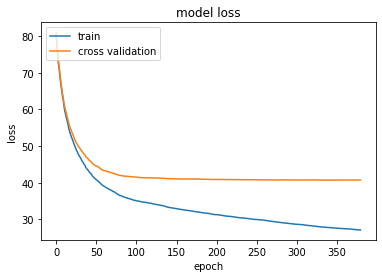

Root Mean Square error of model Trial :  40.73014875928882


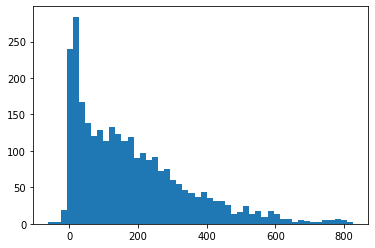

In [ ]:
param = {
    'max_depth': 10, 
    'eta': 10, 
    'objective': 'reg:squarederror', 
    'eval_metric' : 'rmse', 
    'n_estimators' : 400, 
    'reg_lambda' : 100, 
    'min_child_weight': 70, 
    'subsample' : 1, 
    'reg_alpha' : 50
    }

clf = XGBRegressor(**param)

clf.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), (X_test, y_test)], 
        eval_metric = 'rmse', 
        verbose = True)

evals_result = clf.evals_result()

plot_log_xgb(evals_result, 20)
print(f"Root Mean Square error of model Trial : ", mean_squared_error(np.power(clf.predict(X_test), 1), np.power(y_test, 1), squared = False))
plt.hist(np.power(clf.predict(X_test), 1), bins = 50)
plt.show()

[14:36:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:230.95	validation_1-rmse:233.715
[1]	validation_0-rmse:222.421	validation_1-rmse:225.026
[2]	validation_0-rmse:214.363	validation_1-rmse:216.8
[3]	validation_0-rmse:205.915	validation_1-rmse:208.125
[4]	validation_0-rmse:198.84	validation_1-rmse:200.892
[5]	validation_0-rmse:193.487	validation_1-rmse:195.429
[6]	validation_0-rmse:184.671	validation_1-rmse:186.493
[7]	validation_0-rmse:177.225	validation_1-rmse:178.964
[8]	validation_0-rmse:173.039	validation_1-rmse:174.656
[9]	validation_0-rmse:169.26	validation_1-rmse:170.77
[10]	validation_0-rmse:165.113	validation_1-rmse:166.505
[11]	validation_0-rmse:161.524	validation_1-rmse:162.848
[12]	validation_0-rmse:158.741	validation_1-rmse:159.954
[13]	validation_0-rmse:153.192	validation_1-rmse:154.317
[14]	validation_0-rmse:151.162	validation_1-rmse:152.23
[15]	validation_0-rmse:146.338	vali

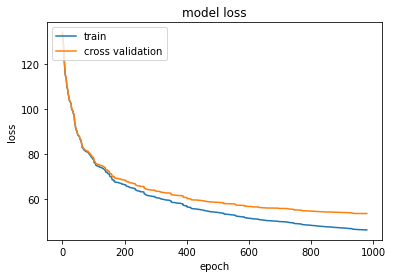

Root Mean Square error of model Trial :  53.708116002712686


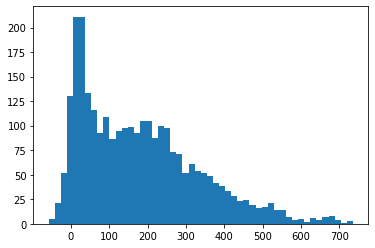

In [ ]:
clf = XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
clf.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), (X_test, y_test)], 
        eval_metric = 'rmse', 
        verbose = True)

evals_result = clf.evals_result()

plot_log_xgb(evals_result, 20)
print(f"Root Mean Square error of model Trial : ", mean_squared_error(np.power(clf.predict(X_test), 1), np.power(y_test, 1), squared = False))
plt.hist(np.power(clf.predict(X_test), 1), bins = 50)
plt.show()

In [ ]:
# Loading data in to DMatrix
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

# Create the parameter grid based
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

num_boost_rounds = 10000

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round = num_boost_rounds,
    evals = [(dtest, "Test")],
    early_stopping_rounds = 10
)

print("Best RSME: {:.2f} with {} rounds".format(
                 xgb_model.best_score,
                 xgb_model.best_iteration+1))

[0]	Test-rmse:183.306
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:143.299
[2]	Test-rmse:112.126
[3]	Test-rmse:92.3315
[4]	Test-rmse:80.5213
[5]	Test-rmse:71.8268
[6]	Test-rmse:63.3995
[7]	Test-rmse:60.0848
[8]	Test-rmse:54.8823
[9]	Test-rmse:52.937
[10]	Test-rmse:51.7759
[11]	Test-rmse:50.2572
[12]	Test-rmse:48.6811
[13]	Test-rmse:46.9936
[14]	Test-rmse:46.6802
[15]	Test-rmse:46.2913
[16]	Test-rmse:45.7623
[17]	Test-rmse:45.4326
[18]	Test-rmse:45.0423
[19]	Test-rmse:44.8585
[20]	Test-rmse:44.7925
[21]	Test-rmse:44.5365
[22]	Test-rmse:44.4301
[23]	Test-rmse:44.3483
[24]	Test-rmse:44.3456
[25]	Test-rmse:44.171
[26]	Test-rmse:44.1163
[27]	Test-rmse:44.0307
[28]	Test-rmse:43.9373
[29]	Test-rmse:43.8605
[30]	Test-rmse:43.8857
[31]	Test-rmse:43.9053
[32]	Test-rmse:43.8628
[33]	Test-rmse:43.8325
[34]	Test-rmse:43.6797
[35]	Test-rmse:43.7334
[36]	Test-rmse:43.71
[37]	Test-rmse:43.6963
[38]	Test-rmse:43.6843
[39]	Test-rmse:43.727
[40]	Test-rmse:43.479
[41]	Test-rmse:4

In [ ]:
# Testing cv 
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round = num_boost_rounds,
    seed = 42,
    nfold = 5,
    metrics = {'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,181.427170,0.843805,181.664526,4.469534
1,141.650537,0.638815,142.364489,4.033636
2,115.631273,0.738251,116.606560,3.958923
3,96.032526,1.067600,97.244885,3.557475
4,82.037666,0.446710,83.857806,3.178462
...,...,...,...,...
57,28.607710,0.627315,43.883256,1.228335
58,28.432031,0.552566,43.894562,1.227032
59,28.222992,0.508963,43.882229,1.234190
60,28.076732,0.581642,43.863899,1.233055


In [ ]:
cv_results['test-rmse-mean'].min()

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in np.arange(4, 10, 1)
    for min_child_weight in np.arange(1, 14, 2)
]

min_rmse = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(max_depth, min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_rounds,
        seed = 42,
        nfold = 5,
        metrics={'rmse'},
        early_stopping_rounds = 10
    )
    # Update best rmse

    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()

    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=4, min_child_weight=8
	RMSE 45.975024999999995 for 185 rounds
CV with max_depth=4, min_child_weight=10
	RMSE 45.697058 for 187 rounds
CV with max_depth=4, min_child_weight=12
	RMSE 46.0252 for 159 rounds
CV with max_depth=5, min_child_weight=8
	RMSE 43.82716739999999 for 91 rounds
CV with max_depth=5, min_child_weight=10
	RMSE 43.3571188 for 116 rounds
CV with max_depth=5, min_child_weight=12
	RMSE 43.51852340000001 for 86 rounds
CV with max_depth=6, min_child_weight=8
	RMSE 42.9862624 for 38 rounds
CV with max_depth=6, min_child_weight=10
	RMSE 43.045848 for 57 rounds
CV with max_depth=6, min_child_weight=12
	RMSE 43.3111304 for 45 rounds
CV with max_depth=7, min_child_weight=8
	RMSE 42.3461998 for 40 rounds
CV with max_depth=7, min_child_weight=10
	RMSE 42.2324006 for 34 rounds
CV with max_depth=7, min_child_weight=12
	RMSE 42.055136999999995 for 34 rounds
CV with max_depth=8, min_child_weight=8
	RMSE 41.8013712 for 29 rounds
CV with max_depth=8, min_child_weight=10

In [ ]:
# Setting best parameters
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(subsample, colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_rounds,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	RMSE 41.524758999999996 for 22 rounds
CV with subsample=1.0, colsample=0.9
	RMSE 41.799083 for 30 rounds
CV with subsample=1.0, colsample=0.8
	RMSE 47.287954 for 32 rounds
CV with subsample=1.0, colsample=0.7
	RMSE 48.1355958 for 43 rounds
CV with subsample=0.9, colsample=1.0
	RMSE 41.74747240000001 for 19 rounds
CV with subsample=0.9, colsample=0.9
	RMSE 42.9627676 for 23 rounds
CV with subsample=0.9, colsample=0.8
	RMSE 47.1337326 for 28 rounds
CV with subsample=0.9, colsample=0.7
	RMSE 48.5536904 for 38 rounds
CV with subsample=0.8, colsample=1.0
	RMSE 42.22087019999999 for 20 rounds
CV with subsample=0.8, colsample=0.9
	RMSE 43.0236428 for 27 rounds
CV with subsample=0.8, colsample=0.8
	RMSE 47.9599056 for 31 rounds
CV with subsample=0.8, colsample=0.7
	RMSE 49.047484600000004 for 30 rounds
CV with subsample=0.7, colsample=1.0
	RMSE 42.2181566 for 18 rounds
CV with subsample=0.7, colsample=0.9
	RMSE 43.6304792 for 20 rounds
CV with subsample=0.

In [ ]:
# Setting best parameters
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

In [ ]:
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, 0.02, 0.01]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_rounds,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

CV with eta=0.3
	RMSE 41.524758999999996 for 22 rounds

CV with eta=0.2
	RMSE 40.671248000000006 for 39 rounds

CV with eta=0.1
	RMSE 39.97760459999999 for 110 rounds

CV with eta=0.05
	RMSE 39.864012800000005 for 230 rounds

CV with eta=0.02
	RMSE 39.642524 for 448 rounds

CV with eta=0.01
	RMSE 39.7305656 for 912 rounds

Best params: 0.02, RMSE: 39.642524


In [ ]:
params['eta'] = best_params

In [ ]:
gridsearch_params = [
    (reg_lambda)
    for reg_lambda in np.arange(0, 10)
]

In [ ]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for reg_lambda in gridsearch_params:
    print("CV with reg_lambda={}".format(reg_lambda))
    # We update our parameters
    params['reg_lambda'] = reg_lambda

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_rounds,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = reg_lambda
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

CV with reg_lambda=0
	RMSE 40.0262642 for 423 rounds
CV with reg_lambda=1
	RMSE 39.642524 for 448 rounds
CV with reg_lambda=2
	RMSE 39.4961478 for 513 rounds
CV with reg_lambda=3
	RMSE 39.439681199999995 for 465 rounds
CV with reg_lambda=4
	RMSE 39.252871 for 579 rounds
CV with reg_lambda=5
	RMSE 39.3469324 for 575 rounds
CV with reg_lambda=6
	RMSE 39.3431182 for 613 rounds
CV with reg_lambda=7
	RMSE 39.441661800000006 for 607 rounds
CV with reg_lambda=8
	RMSE 39.525413400000005 for 463 rounds
CV with reg_lambda=9
	RMSE 39.4263672 for 527 rounds
Best params: 4, RMSE: 39.252871


In [ ]:
params['reg_lambda'] = best_params

In [ ]:
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_rounds,
    evals=[(dtest, "Test")],
    early_stopping_rounds = 10
)

# get_prediction_file(best_model, 'XGB_final_2.csv', 1)

[0]	Test-rmse:240.365
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:236.026
[2]	Test-rmse:231.787
[3]	Test-rmse:227.623
[4]	Test-rmse:223.548
[5]	Test-rmse:219.54
[6]	Test-rmse:215.627
[7]	Test-rmse:211.795
[8]	Test-rmse:208.049
[9]	Test-rmse:204.357
[10]	Test-rmse:200.746
[11]	Test-rmse:197.234
[12]	Test-rmse:193.797
[13]	Test-rmse:190.41
[14]	Test-rmse:187.113
[15]	Test-rmse:183.867
[16]	Test-rmse:180.672
[17]	Test-rmse:177.584
[18]	Test-rmse:174.52
[19]	Test-rmse:171.527
[20]	Test-rmse:168.6
[21]	Test-rmse:165.734
[22]	Test-rmse:162.924
[23]	Test-rmse:160.178
[24]	Test-rmse:157.485
[25]	Test-rmse:154.872
[26]	Test-rmse:152.309
[27]	Test-rmse:149.77
[28]	Test-rmse:147.314
[29]	Test-rmse:144.88
[30]	Test-rmse:142.508
[31]	Test-rmse:140.173
[32]	Test-rmse:137.896
[33]	Test-rmse:135.701
[34]	Test-rmse:133.504
[35]	Test-rmse:131.384
[36]	Test-rmse:129.288
[37]	Test-rmse:127.225
[38]	Test-rmse:125.225
[39]	Test-rmse:123.265
[40]	Test-rmse:121.352
[41]	Test-rmse:11

## Part 3 : One Hot encoding and addressing skewed features

In [ ]:
test_df['O/P'] = -1

# Concatinating train_f and test_df to process them simultaneously
df = pd.concat((train_df, test_df), axis = 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.describe()

,F3,F4,F6,F7,F8,F9,F10,F11,F12,F13,F14,F16,F17,O/P
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,1.737900e+04,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,10062.115024,11.546752,0.028770,3.003683,14.530871,0.682721,1.425283,0.496987,-9.624030e-04,0.627229,0.190098,141.124058
std,1.106918,0.500008,5813.483605,6.914405,0.167165,2.005771,8.668902,0.465431,0.639357,0.192556,1.001029e+00,0.192930,0.122340,165.981164
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,-3.814712e+00,0.000000,0.000000,-1.000000
25%,2.000000,0.000000,5007.000000,6.000000,0.000000,1.000000,7.000000,0.000000,1.000000,0.340000,-6.679182e-01,0.480000,0.104500,6.000000
50%,3.000000,1.000000,10163.000000,12.000000,0.000000,3.000000,15.000000,1.000000,1.000000,0.500000,-8.439582e-07,0.630000,0.194000,84.000000
75%,3.000000,1.000000,15113.000000,18.000000,0.000000,5.000000,22.000000,1.000000,2.000000,0.660000,6.742244e-01,0.780000,0.253700,221.000000
max,4.000000,1.000000,19997.000000,23.000000,1.000000,6.000000,29.000000,1.000000,4.000000,1.000000,3.377195e+00,1.000000,0.850700,957.000000


In [ ]:
dummy_columns = ['F3', 'F4', 'F5', 'F7', 'F8', 'F9', 'F11', 'F12']

# Dropping all Skewed columns
"""
for column in df.columns:
    if df[column].skew() > 0.5 and column != 'O/P':
        df.drop(labels=column, axis=1, inplace=True)
        print(column)
"""

# Mean Std Transformation
"""
for column in df.columns:
    if column not in dummy_columns and column != 'O/P':
        standard_deviation = df[column].std(axis = 0)
        mean = df[column].mean(axis = 0)
        df[column] = (df[column] - mean) / standard_deviation
    if abs(df[column].skew()) > 1 and column != 'O/P' and column not in dummy_columns:
        df[column] = np.log(df[column] + 1)
    if abs(df[column].skew() > 1) and column != 'O/P':
        print(df[column].skew())
        df.drop(column, inplace = True, axis = 1)
        removed_columns.append(column)
"""

# Min Max Transformation

for column in df.columns:
    if column not in dummy_columns and column != 'O/P':
        minimum = df[column].min(axis = 0)
        maximum = df[column].max(axis = 0)
        df[column] = (df[column] - minimum) / (maximum - minimum)
    if abs(df[column].skew()) > 1 and column != 'O/P' and column not in dummy_columns:
        df[column] = np.log(df[column] + 1)
    if abs(df[column].skew() > 1) and column != 'O/P':
        print(df[column].skew())
        df.drop(column, inplace = True, axis = 1)
        removed_columns.append(column)


5.6385379928840065
1.2280467231680767


In [ ]:
print(removed_columns)
df.info()

['F5', 'F15', 'F8', 'F12']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F3      17379 non-null  float64
 1   F4      17379 non-null  float64
 2   F6      17379 non-null  float64
 3   F7      17379 non-null  float64
 4   F9      17379 non-null  float64
 5   F10     17379 non-null  float64
 6   F11     17379 non-null  float64
 7   F13     17379 non-null  float64
 8   F14     17379 non-null  float64
 9   F16     17379 non-null  float64
 10  F17     17379 non-null  float64
 11  O/P     17379 non-null  float64
dtypes: float64(12)
memory usage: 1.7 MB


In [ ]:
df.describe()

,F3,F4,F6,F7,F9,F10,F11,F13,F14,F16,F17,O/P
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,0.503156,11.546752,3.003683,0.501065,0.682721,0.486722,0.530284,0.627229,0.223460,141.124058
std,1.106918,0.500008,0.290732,6.914405,2.005771,0.298928,0.465431,0.196486,0.139188,0.192930,0.143811,165.981164
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,2.000000,0.000000,0.250350,6.000000,1.000000,0.241379,0.000000,0.326531,0.437547,0.480000,0.122840,6.000000
50%,3.000000,1.000000,0.508202,12.000000,3.000000,0.517241,1.000000,0.489796,0.530417,0.630000,0.228047,84.000000
75%,3.000000,1.000000,0.755751,18.000000,5.000000,0.758621,1.000000,0.653061,0.624165,0.780000,0.298225,221.000000
max,4.000000,1.000000,1.000000,23.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,957.000000


In [ ]:
df.head()

,F3,F4,F6,F7,F9,F10,F11,F13,F14,F16,F17,O/P
0,1.0,0.0,0.725745,0.0,6.0,0.275862,0.0,0.224490,0.656646,0.81,0.0,16.0
1,1.0,0.0,0.089468,1.0,6.0,0.448276,0.0,0.204082,0.535322,0.80,0.0,40.0
2,1.0,0.0,0.851470,2.0,6.0,0.586207,0.0,0.204082,0.540068,0.80,0.0,32.0
3,1.0,0.0,0.844569,3.0,6.0,0.586207,0.0,0.224490,0.646616,0.75,0.0,13.0
4,1.0,0.0,0.252050,4.0,6.0,0.275862,0.0,0.224490,0.652334,0.75,0.0,1.0


In [ ]:
# Getting Dummy Variables
real_dummies = [column for column in dummy_columns if column not in removed_columns]
print(removed_columns)
print(real_dummies)
df = pd.get_dummies(df, columns = real_dummies)

['F5', 'F15', 'F8', 'F12']
['F3', 'F4', 'F7', 'F9', 'F11']


In [ ]:
train_df = df.loc[0:(14000-1), :]
test_df = df.loc[14000:, :]
test_df.drop('O/P', inplace = True, axis = 1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
 # save_files('Train_data_norm_unskew.csv', 'Test_data_norm_unskew.csv')
 X, y, X_train, y_train, X_test, y_test, X_predict, train_df, test_df = load_data_into_np(train_df, test_df)

## Neural Networks (MLPRegressor)

In [ ]:
regr_1 = MLPRegressor(random_state = 1, max_iter = 10000)

test_model(regr_1, 1, X, y)

# get_prediction_file(regr_1, 'nn_1.3.csv', 1)

Root Mean Square error of model Trial 1:  48.59289870393259


## Tensor Flow Deep Learning Models

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Flatten())
model.add(Dense(500, activation = tf.nn.relu))
model.add(Dense(200, activation = tf.nn.relu))
model.add(Dense(100, activation = tf.nn.relu))
model.add(Dropout(0.3))
model.add(Dense(1, activation = tf.nn.relu))

model.compile(optimizer = 'adam' , loss = 'mse', metrics = ['mse'])

history = model.fit(X_train, y_train, epochs = 50, batch_size = 10,  validation_data=(X_test, y_test))

Epoch 1/50
1120/1120 [==============================] - 3s 3ms/step - loss: 9340.1924 - mse: 9340.1924 - val_loss: 3216.1536 - val_mse: 3216.1538
Epoch 2/50
1120/1120 [==============================] - 3s 3ms/step - loss: 3832.2964 - mse: 3832.2964 - val_loss: 3536.0056 - val_mse: 3536.0056
Epoch 3/50
1120/1120 [==============================] - 3s 3ms/step - loss: 3491.1340 - mse: 3491.1340 - val_loss: 2911.0256 - val_mse: 2911.0256
Epoch 4/50
1120/1120 [==============================] - 3s 2ms/step - loss: 3311.6406 - mse: 3311.6406 - val_loss: 2740.0701 - val_mse: 2740.0701
Epoch 5/50
1120/1120 [==============================] - 3s 2ms/step - loss: 3311.4692 - mse: 3311.4692 - val_loss: 2840.3186 - val_mse: 2840.3186
Epoch 6/50
1120/1120 [==============================] - 3s 2ms/step - loss: 3138.7446 - mse: 3138.7446 - val_loss: 2732.7183 - val_mse: 2732.7183
Epoch 7/50
1120/1120 [==============================] - 3s 2ms/step - loss: 3037.4189 - mse: 3037.4189 - val_loss: 2777.9602

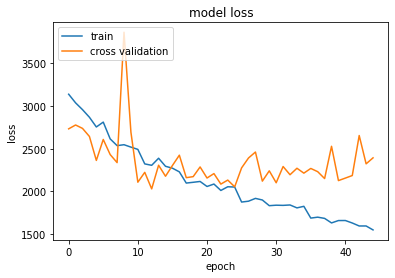

In [ ]:
plot_log(history, 5)

In [ ]:
model = Sequential()
model.add(Flatten())
model.add(Dense(100, activation = tf.nn.relu))
model.add(Dense(100, activation = tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(1, activation = tf.nn.relu))

model.compile(optimizer = 'adam' , loss = 'mse', metrics = ['mse'])

history = model.fit(X_train, y_train, epochs = 20, batch_size = 10,  validation_data=(X_test, y_test))

Epoch 1/20
1120/1120 [==============================] - 2s 2ms/step - loss: 16721.4785 - mse: 16721.4785 - val_loss: 7779.1978 - val_mse: 7779.1978
Epoch 2/20
1120/1120 [==============================] - 2s 2ms/step - loss: 7178.5977 - mse: 7178.5977 - val_loss: 5633.4370 - val_mse: 5633.4370
Epoch 3/20
1120/1120 [==============================] - 2s 1ms/step - loss: 4870.2642 - mse: 4870.2642 - val_loss: 3614.3740 - val_mse: 3614.3740
Epoch 4/20
1120/1120 [==============================] - 2s 1ms/step - loss: 3726.9260 - mse: 3726.9260 - val_loss: 3090.7078 - val_mse: 3090.7078
Epoch 5/20
1120/1120 [==============================] - 2s 1ms/step - loss: 3362.4392 - mse: 3362.4392 - val_loss: 2989.3809 - val_mse: 2989.3809
Epoch 6/20
1120/1120 [==============================] - 2s 2ms/step - loss: 3303.7029 - mse: 3303.7031 - val_loss: 2849.9016 - val_mse: 2849.9016
Epoch 7/20
1120/1120 [==============================] - 2s 1ms/step - loss: 3187.0735 - mse: 3187.0735 - val_loss: 3065.16

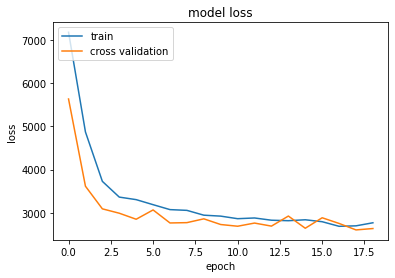

In [ ]:
plot_log(history, 1)

In [ ]:
model = Sequential()
model.add(Flatten())
model.add(Dense(1000, activation = tf.nn.relu))
model.add(Dense(1000, activation = tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(1, activation = tf.nn.relu))

model.compile(optimizer = 'adam' , loss = 'mse', metrics = ['mse'])

history = model.fit(X_train, y_train, epochs = 20, batch_size = 10,  validation_data=(X_test, y_test))

Epoch 1/20
1120/1120 [==============================] - 12s 11ms/step - loss: 7628.6416 - mse: 7628.6416 - val_loss: 3186.8845 - val_mse: 3186.8845
Epoch 2/20
1120/1120 [==============================] - 12s 10ms/step - loss: 3197.5957 - mse: 3197.5957 - val_loss: 2916.9612 - val_mse: 2916.9612
Epoch 3/20
1120/1120 [==============================] - 12s 10ms/step - loss: 2963.2065 - mse: 2963.2065 - val_loss: 2887.1919 - val_mse: 2887.1919
Epoch 4/20
1120/1120 [==============================] - 12s 10ms/step - loss: 2773.6274 - mse: 2773.6274 - val_loss: 2917.2683 - val_mse: 2917.2683
Epoch 5/20
1120/1120 [==============================] - 12s 10ms/step - loss: 2694.5596 - mse: 2694.5596 - val_loss: 2812.9939 - val_mse: 2812.9941
Epoch 6/20
1120/1120 [==============================] - 12s 10ms/step - loss: 2622.9722 - mse: 2622.9719 - val_loss: 2706.1924 - val_mse: 2706.1924
Epoch 7/20
1120/1120 [==============================] - 12s 10ms/step - loss: 2527.1265 - mse: 2527.1265 - val_l

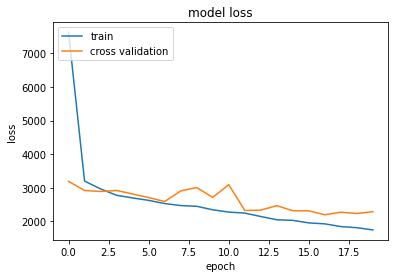

In [ ]:
plot_log(history, 0)

In [ ]:
model = Sequential()
model.add(Flatten())
model.add(Dense(1000, activation = 'linear'))
model.add(Dense(1000, activation = tf.nn.relu))
model.add(Dropout(0.3))
model.add(Dense(1, activation = tf.nn.relu))

model.compile(optimizer = 'adam' , loss = 'mse', metrics = ['mse'])

history = model.fit(X_train, y_train, epochs = 50, batch_size = 10,  validation_data=(X_test, y_test))

Epoch 1/20
1120/1120 [==============================] - 12s 10ms/step - loss: 10067.8076 - mse: 10067.8076 - val_loss: 5299.4409 - val_mse: 5299.4409
Epoch 2/20
1120/1120 [==============================] - 12s 10ms/step - loss: 4409.3882 - mse: 4409.3882 - val_loss: 3318.8611 - val_mse: 3318.8611
Epoch 3/20
1120/1120 [==============================] - 12s 10ms/step - loss: 3727.9707 - mse: 3727.9712 - val_loss: 3155.0369 - val_mse: 3155.0369
Epoch 4/20
1120/1120 [==============================] - 12s 10ms/step - loss: 3598.3650 - mse: 3598.3650 - val_loss: 3047.0925 - val_mse: 3047.0925
Epoch 5/20
1120/1120 [==============================] - 12s 10ms/step - loss: 3463.4182 - mse: 3463.4182 - val_loss: 3391.0269 - val_mse: 3391.0269
Epoch 6/20
1120/1120 [==============================] - 12s 11ms/step - loss: 3353.0308 - mse: 3353.0308 - val_loss: 3105.5913 - val_mse: 3105.5913
Epoch 7/20
1120/1120 [==============================] - 13s 12ms/step - loss: 3221.3015 - mse: 3221.3015 - val

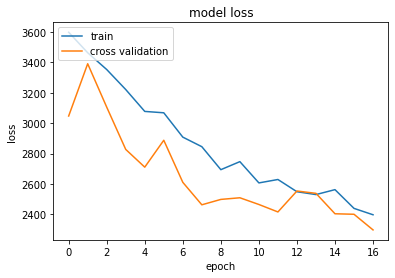

In [ ]:
plot_log(history, 3)

####Since the given outputs were skewed, I also tried applying log transformation / sqrt transformation on it. This however did not improve the accuracy of my models by much.

# Best Models


*  XG BOOST - 37 RSME on Local Test / 71 RMSE on Kaggle
*  Random Forest Regressor - 39 RMSE on Local Test / 72 RMSE on Kaggle
*  SKlearn MLP NN Regressor - 42 RMSE on Local Test / 71 RMSE on Kaggle
*  Tensorflow NN Regressor - 42 RMSE on Local Test / 71 RMSE on Kaggle

The above errors are after Hyper parameter tuning and local test refers to test train split.



# This is the work of Anirudh Achal